In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os  

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV

# Data

In [2]:
path1 = '/home/mcalmeida/machine-learning/projects/neoway-case/data/conexoes_espec.csv'
path2 = '/home/mcalmeida/machine-learning/projects/neoway-case/data/individuos_espec.csv'

In [3]:
df_conexoes = pd.read_csv(path1,sep=';')
df_individuos = pd.read_csv(path2,sep=';')

In [4]:
df_conexoes.head()

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN


In [5]:
df_individuos.head()

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668


In [6]:
V1 = df_individuos.copy()
V1.columns = V1.columns + '_1'

In [7]:
V2 = df_individuos.copy()
V2.columns = V2.columns + '_2'

In [8]:
df_temp1 = df_conexoes.merge(V1, left_on='V1', right_on='name_1')

In [9]:
df_final = df_temp1.merge(V2, left_on='V2', right_on='name_2')

In [10]:
df_known = df_final[~df_final['prob_V1_V2'].isna()]

In [11]:
df_unknown = df_final[df_final['prob_V1_V2'].isna()]

In [12]:
(df_known.corr()).style.background_gradient(cmap='coolwarm')

,V1,V2,prob_V1_V2,name_1,idade_1,qt_filhos_1,estuda_1,trabalha_1,pratica_esportes_1,IMC_1,name_2,idade_2,qt_filhos_2,estuda_2,trabalha_2,pratica_esportes_2,IMC_2
V1,1.000000,1.000000,-0.001129,1.000000,-0.002027,-0.000043,0.000017,0.002362,-0.001017,-0.002404,1.000000,-0.000515,0.000614,-0.001129,0.000067,-0.001703,-0.000498
V2,1.000000,1.000000,-0.001129,1.000000,-0.002027,-0.000043,0.000017,0.002362,-0.001017,-0.002404,1.000000,-0.000515,0.000614,-0.001129,0.000067,-0.001703,-0.000498
prob_V1_V2,-0.001129,-0.001129,1.000000,-0.001129,-0.046308,-0.023822,0.089574,-0.371803,0.350341,0.001790,-0.001129,-0.019700,-0.002663,0.002761,-0.002882,-0.002561,0.033103
name_1,1.000000,1.000000,-0.001129,1.000000,-0.002027,-0.000043,0.000017,0.002362,-0.001017,-0.002404,1.000000,-0.000515,0.000614,-0.001129,0.000067,-0.001703,-0.000498
idade_1,-0.002027,-0.002027,-0.046308,-0.002027,1.000000,0.115732,-0.141664,0.139151,0.000489,-0.000468,-0.002027,0.000420,0.002158,0.001408,-0.000815,-0.001751,0.000263
qt_filhos_1,-0.000043,-0.000043,-0.023822,-0.000043,0.115732,1.000000,-0.081414,0.082140,0.000538,-0.002991,-0.000043,-0.000045,0.000126,-0.001074,0.002128,0.000351,0.003115
estuda_1,0.000017,0.000017,0.089574,0.000017,-0.141664,-0.081414,1.000000,-0.098126,-0.000666,0.000183,0.000017,0.002261,0.000604,-0.002774,-0.001203,0.001545,-0.002827
trabalha_1,0.002362,0.002362,-0.371803,0.002362,0.139151,0.082140,-0.098126,1.000000,0.002481,-0.004831,0.002362,-0.000260,-0.001463,0.002003,-0.002042,0.000225,0.001751
pratica_esportes_1,-0.001017,-0.001017,0.350341,-0.001017,0.000489,0.000538,-0.000666,0.002481,1.000000,0.000291,-0.001017,-0.002108,-0.001098,0.000177,-0.001132,0.000194,0.000111
IMC_1,-0.002404,-0.002404,0.001790,-0.002404,-0.000468,-0.002991,0.000183,-0.004831,0.000291,1.000000,-0.002404,0.000608,-0.001869,0.000825,-0.000762,-0.000852,0.001191


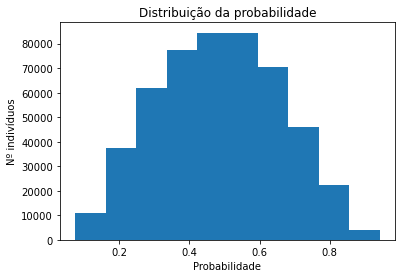

In [76]:
probabilidade = df_known['prob_V1_V2']
_ = plt.hist(probabilidade)
_ = plt.xlabel("Probabilidade")
_ = plt.ylabel("Nº indivíduos")
_ = plt.title("Distribuição da probabilidade")
plt.show();

# Input Missing Values

In [13]:
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [92]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a regression.
    """
    r2 = r2_score(y_true, y_preds)
    mae = mean_absolute_error(y_true, y_preds)
    mse = mean_squared_error(y_true, y_preds)
    max_err = max_error(y_true, y_preds)
    metric_dict = {"r2": round(r2, 5),
                   "mae": round(mae, 5),
                   "mse": round(mse, 5),
                   "mas": round(max_err, 5)}
    print(f"R² score: {r2:.3f}")
    print(f"Mean absolute error: {mae:.3f}")
    print(f"Mean squared error: {mse:.3f}")
    print(f"Max error: {max_err:.3f}")
    
    return metric_dict

# Data spliting

In [42]:
df_temp = df_known.drop(['V1','V2','name_1','name_2'], axis=1)

In [43]:
df_temp.head()

,grau,proximidade,prob_V1_V2,idade_1,estado_civil_1,qt_filhos_1,estuda_1,trabalha_1,pratica_esportes_1,transporte_mais_utilizado_1,IMC_1,idade_2,estado_civil_2,qt_filhos_2,estuda_2,trabalha_2,pratica_esportes_2,transporte_mais_utilizado_2,IMC_2
0,trabalho,visita_frequente,0.589462,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
1,trabalho,visita_rara,0.708465,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,trabalho,visita_rara,0.638842,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
5,familia,visita_casual,0.709608,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,55.0,solteiro,1.0,1.0,1.0,1.0,particular,NaN
7,amigos,visita_casual,0.465209,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053,42.0,divorciado,1.0,0.0,1.0,NaN,publico,40.793339


In [44]:
# Shuffle the data
np.random.seed(42)
df_shuffled = df_temp.sample(frac=1)

In [45]:
df_shuffled.head()

,grau,proximidade,prob_V1_V2,idade_1,estado_civil_1,qt_filhos_1,estuda_1,trabalha_1,pratica_esportes_1,transporte_mais_utilizado_1,IMC_1,idade_2,estado_civil_2,qt_filhos_2,estuda_2,trabalha_2,pratica_esportes_2,transporte_mais_utilizado_2,IMC_2
208657,familia,visita_rara,0.324920,30.0,divorciado,0.0,0.0,0.0,0.0,publico,20.382146,19.0,solteiro,3.0,0.0,1.0,1.0,particular,22.024349
399816,amigos,visita_rara,0.663947,48.0,casado,1.0,0.0,0.0,1.0,particular,19.142755,36.0,divorciado,1.0,0.0,1.0,1.0,publico,NaN
280646,familia,visita_frequente,0.394388,37.0,viuvo,2.0,0.0,0.0,NaN,particular,23.301253,30.0,solteiro,4.0,0.0,1.0,1.0,publico,22.695043
265789,trabalho,visita_rara,0.511199,NaN,divorciado,0.0,0.0,0.0,0.0,publico,24.696776,23.0,solteiro,0.0,1.0,1.0,1.0,taxi,29.660348
817534,trabalho,visita_casual,0.248089,37.0,casado,1.0,0.0,1.0,0.0,taxi,17.265800,27.0,solteiro,1.0,1.0,1.0,1.0,publico,20.440223


In [46]:
# Split into X & y
X_temp = df_shuffled.drop("prob_V1_V2", axis=1)
y_temp = df_shuffled["prob_V1_V2"]

In [47]:
np.random.seed(42)
# Split the data into train, validation & test sets
train_split = round(0.85 * len(df_shuffled)) # 85% of data
X, y = X_temp[:train_split], y_temp[:train_split]
X_test, y_test = X_temp[train_split:], y_temp[train_split:]

# Data cleaning

In [48]:
categorical_features = [
 'grau','proximidade',
 'estado_civil_1','transporte_mais_utilizado_1',
 'estado_civil_2','transporte_mais_utilizado_2'
]

categorical_imputer = SimpleImputer(strategy="most_frequent")

In [49]:
filhos_features = [
    'qt_filhos_1','qt_filhos_2',
]

filhos_imputer = SimpleImputer(strategy="most_frequent")

In [50]:
bool_features = [
 'estuda_1','trabalha_1','estuda_2', 'trabalha_2'
]

bool_imputer = SimpleImputer(strategy="most_frequent")

In [51]:
esporte_features = [
    'pratica_esportes_1','pratica_esportes_2',
]

# 0: não
# 1: sim
# 2: não informado
esporte_imputer = SimpleImputer(strategy="constant", fill_value=2.0)

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424999 entries, 208657 to 656672
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   grau                         424999 non-null  object 
 1   proximidade                  424999 non-null  object 
 2   idade_1                      384071 non-null  float64
 3   estado_civil_1               403786 non-null  object 
 4   qt_filhos_1                  412660 non-null  float64
 5   estuda_1                     407959 non-null  float64
 6   trabalha_1                   422322 non-null  float64
 7   pratica_esportes_1           361547 non-null  float64
 8   transporte_mais_utilizado_1  406505 non-null  object 
 9   IMC_1                        376479 non-null  float64
 10  idade_2                      384483 non-null  float64
 11  estado_civil_2               403687 non-null  object 
 12  qt_filhos_2                  412799 non-null  float64

In [53]:
numeric_features = ['idade_1','idade_2','IMC_1','IMC_2']
numeric_imputer = SimpleImputer(strategy="median")

In [54]:
# Create an imputer (something that fills missing data)
imputer = ColumnTransformer([
    ("categorical_imputer", categorical_imputer, categorical_features),
    ("esporte_imputer", esporte_imputer, esporte_features),
    ("numeric_imputer", numeric_imputer, numeric_features),
    ("filhos_imputer", filhos_imputer, filhos_features),
    ("bool_imputer", bool_imputer, bool_features)
])

In [55]:
columns = categorical_features + esporte_features + numeric_features + filhos_features + bool_features

In [56]:
# Fill train and test values separately
filled_X = imputer.fit_transform(X)
filled_X_test = imputer.transform(X_test)

# Check filled X
filled_X

array([['familia', 'visita_rara', 'divorciado', ..., 0.0, 0.0, 1.0],
       ['amigos', 'visita_rara', 'casado', ..., 0.0, 0.0, 1.0],
       ['familia', 'visita_frequente', 'viuvo', ..., 0.0, 0.0, 1.0],
       ...,
       ['trabalho', 'visita_casual', 'solteiro', ..., 1.0, 0.0, 0.0],
       ['trabalho', 'visita_frequente', 'solteiro', ..., 1.0, 1.0, 1.0],
       ['amigos', 'visita_rara', 'solteiro', ..., 0.0, 0.0, 0.0]],
      dtype=object)

In [57]:
# Get our transformed data array's back into DataFrame's
X_filled = pd.DataFrame(filled_X, 
                                      columns=columns)

X_filled_test = pd.DataFrame(filled_X_test, 
                                     columns=columns)

# Check missing data in training set
X_filled.isna().sum()

grau                           0
proximidade                    0
estado_civil_1                 0
transporte_mais_utilizado_1    0
estado_civil_2                 0
transporte_mais_utilizado_2    0
pratica_esportes_1             0
pratica_esportes_2             0
idade_1                        0
idade_2                        0
IMC_1                          0
IMC_2                          0
qt_filhos_1                    0
qt_filhos_2                    0
estuda_1                       0
trabalha_1                     0
estuda_2                       0
trabalha_2                     0
dtype: int64

In [58]:
X_filled.head()

,grau,proximidade,estado_civil_1,transporte_mais_utilizado_1,estado_civil_2,transporte_mais_utilizado_2,pratica_esportes_1,pratica_esportes_2,idade_1,idade_2,IMC_1,IMC_2,qt_filhos_1,qt_filhos_2,estuda_1,trabalha_1,estuda_2,trabalha_2
0,familia,visita_rara,divorciado,publico,solteiro,particular,0.0,1.0,30.0,19.0,20.382146,22.024349,0.0,3.0,0.0,0.0,0.0,1.0
1,amigos,visita_rara,casado,particular,divorciado,publico,1.0,1.0,48.0,36.0,19.142755,21.423458,1.0,1.0,0.0,0.0,0.0,1.0
2,familia,visita_frequente,viuvo,particular,solteiro,publico,2.0,1.0,37.0,30.0,23.301253,22.695043,2.0,4.0,0.0,0.0,0.0,1.0
3,trabalho,visita_rara,divorciado,publico,solteiro,taxi,0.0,1.0,29.0,23.0,24.696776,29.660348,0.0,0.0,0.0,0.0,1.0,1.0
4,trabalho,visita_casual,casado,taxi,solteiro,publico,0.0,1.0,37.0,27.0,17.2658,20.440223,1.0,1.0,0.0,1.0,1.0,1.0


In [60]:
# Now let's one hot encode the features with the same code as before 
cat_features = categorical_features

one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot", 
                                 one_hot, 
                                 cat_features)],
                                 remainder="passthrough")

# Fill train and test values separately
transformed_X = transformer.fit_transform(X_filled)
transformed_X_test = transformer.transform(X_filled_test)

In [100]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(transformed_X,y, test_size=0.2,random_state=42)

# Baseline - Linear regression

In [105]:
linear = LinearRegression()

linear.fit(X_train, y_train)

LinearRegression()

In [106]:
y_preds_linear = linear.predict(X_val)

In [108]:
# Evaluate the classifier on validation set
linear_metrics_val = evaluate_preds(y_val, y_preds_linear)
linear_metrics_val

R² score: 0.504
Mean absolute error: 0.099
Mean squared error: 0.015
Max error: 0.510


{'r2': 0.5038, 'mae': 0.09907, 'mse': 0.01499, 'mas': 0.50989}

# Random Forest

In [89]:
model = RandomForestRegressor()

model.fit(X_train, y_train)

RandomForestRegressor()

In [101]:
y_preds_val = model.predict(X_val)

In [102]:
# Evaluate the classifier on validation set
baseline_metrics_val = evaluate_preds(y_val, y_preds_val)
baseline_metrics_val

R² score: 0.898
Mean absolute error: 0.038
Mean squared error: 0.003
Max error: 0.538


{'r2': 0.8976, 'mae': 0.03774, 'mse': 0.00309, 'mas': 0.53846}

In [113]:
print('Redução de {:0.2f}%. no erro médio absoluto'.format( 100 * (linear_metrics_val['mae']- baseline_metrics_val['mae']) / linear_metrics_val['mae']))

Redução de 61.91%. no erro médio absoluto


# Cross Validation

In [62]:
from sklearn.model_selection import cross_val_score

In [65]:
np.random.seed(42)
cv_r2 = cross_val_score(model, transformed_X, y, cv=5, scoring=None)
cv_r2

array([0.89706941, 0.89644224, 0.89546167, 0.89689573, 0.89730609])

In [67]:
print(f"The cross-validated R²-score is: {np.mean(cv_r2)}")

The cross-validated R²-score is: 0.8966350284017354


In [72]:
np.random.seed(42)
cv_mse = cross_val_score(model, transformed_X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse

array([-0.00309951, -0.00313358, -0.00313614, -0.00312624, -0.00312883])

In [73]:
print(f"The cross-validated MSE-score is: {np.mean(cv_mse)}")

The cross-validated MSE-score is: -0.0031248616140817855


In [74]:
np.random.seed(42)
cv_mae = cross_val_score(model, transformed_X, y, cv=5, scoring='neg_mean_absolute_error')
cv_mae

array([-0.03756373, -0.0376785 , -0.0378855 , -0.03772514, -0.03780301])

In [75]:
print(f"The cross-validated MAE-score is: {np.mean(cv_mae)}")

The cross-validated MAE-score is: -0.03773117566808946


# Hyperparameter tuning

In [95]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [96]:
from sklearn.model_selection import RandomizedSearchCV

In [97]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [98]:
rf_random = RandomizedSearchCV(estimator=model,
                            param_distributions=random_grid, 
                            n_iter=10, # number of models to try
                            cv=3,
                            verbose=2,
                            random_state=42)

In [99]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  49.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  49.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  50.3s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 3.8min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 4.2min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 4.5min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=6

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [103]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

In [115]:
tuned_model = rf_random.best_estimator_

In [116]:
y_preds_tuned = tuned_model.predict(X_val)
tuned_metrics = evaluate_preds(y_val, y_preds_tuned)
tuned_metrics

R² score: 0.903
Mean absolute error: 0.037
Mean squared error: 0.003
Max error: 0.511


{'r2': 0.90338, 'mae': 0.03678, 'mse': 0.00292, 'mas': 0.51144}

In [117]:
print('Redução de {:0.2f}%. no erro médio absoluto'.format( 100 * (baseline_metrics_val['mae']- tuned_metrics['mae']) / baseline_metrics_val['mae']))

Redução de 2.54%. no erro médio absoluto


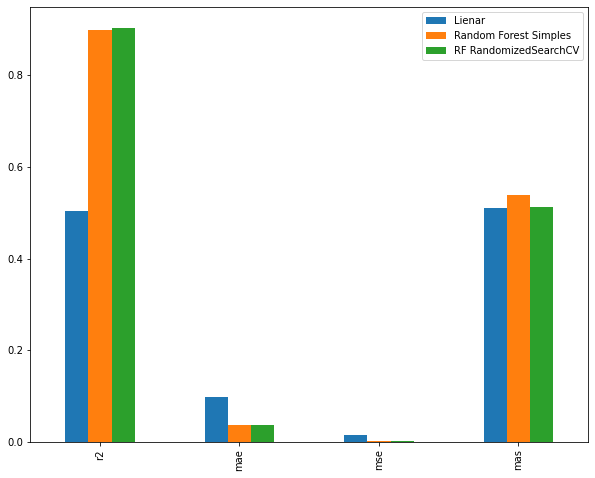

In [119]:
compare_metrics = pd.DataFrame({"Lienar": linear_metrics_val,
                                "Random Forest Simples": baseline_metrics_val,
                                "RF RandomizedSearchCV": tuned_metrics})

compare_metrics.plot.bar(figsize=(10, 8));

# Save model

In [120]:
import pickle

pickle.dump(tuned_model, open("rf_final.pkl", "wb"))

# Configuration fo the final model 

In [ ]:
final_model_hyperparams = {'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}